In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
  
od.download("https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge")
# {"username":"sudhanshuvashisth03","key":"30fccead6f95682028af046d2942aa06"}   ----> for download of the kaggle files

Skipping, found downloaded files in "./jigsaw-toxic-comment-classification-challenge" (use force=True to force download)


In [ ]:
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
train_df=pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/train.csv")
test_df=pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels=pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [ ]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
print('%d features and %d records.' % (train_df.shape[1], train_df.shape[0]))
print()
targets = list(train_df.columns[2:])
print('Target columns: ' + ', '.join(targets))

8 features and 159571 records.

Target columns: toxic, severe_toxic, obscene, threat, insult, identity_hate


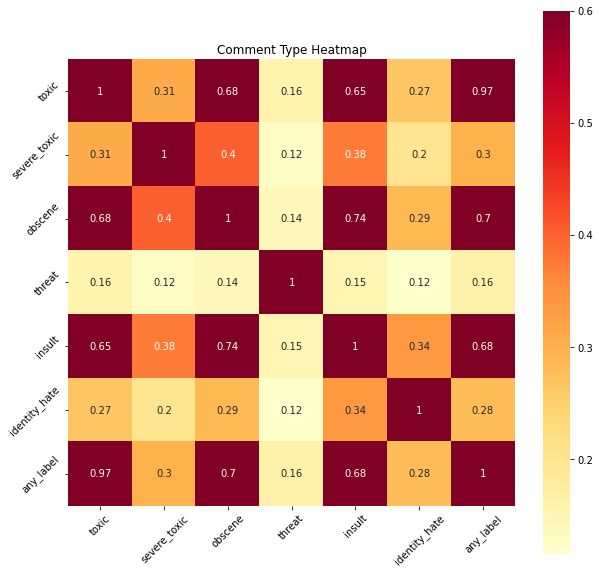

Training Data Comment Breakdown
=====

16225 out of 159571 comments, or 10.17%, are classified as toxic.

15294 toxic comments. (9.58% of all data.)
- 1595 or 10.43% were also severe_toxic.
- 7926 or 51.82% were also obscene.
- 449 or 2.94% were also threat.
- 7344 or 48.02% were also insult.
- 1302 or 8.51% were also identity_hate.
- 15294 or 100.00% were also any_label.

1595 severe_toxic comments. (1.00% of all data.)
- 1595 or 100.00% were also toxic.
- 1517 or 95.11% were also obscene.
- 112 or 7.02% were also threat.
- 1371 or 85.96% were also insult.
- 313 or 19.62% were also identity_hate.
- 1595 or 100.00% were also any_label.

8449 obscene comments. (5.29% of all data.)
- 7926 or 93.81% were also toxic.
- 1517 or 17.95% were also severe_toxic.
- 301 or 3.56% were also threat.
- 6155 or 72.85% were also insult.
- 1032 or 12.21% were also identity_hate.
- 8449 or 100.00% were also any_label.

478 threat comments. (0.30% of all data.)
- 449 or 93.93% were also toxic.
- 112 or 23

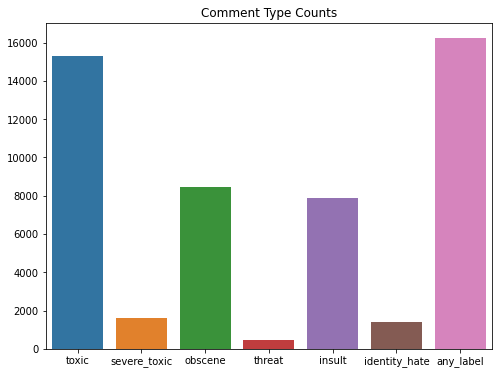

In [ ]:
targets = list(train_df.columns[2:])
df_targets = train_df[targets].copy()

# How many rows are toxic? 
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

# Create overall any_label feature
targets.append('any_label')
df_targets['any_label'] = toxic_rows

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts


del(df_selection)
def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    #df_corr = np.triu(df_corr, k=1)
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Comment Type Heatmap')


print('Training Data Comment Breakdown')
print('=====\n')

print('%d out of %d comments, or %.2f%%, are classified as toxic.' % 
     (np.sum(toxic_rows), len(train_df), (np.sum(toxic_rows)/len(train_df))*100))

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(train_df))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))

plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


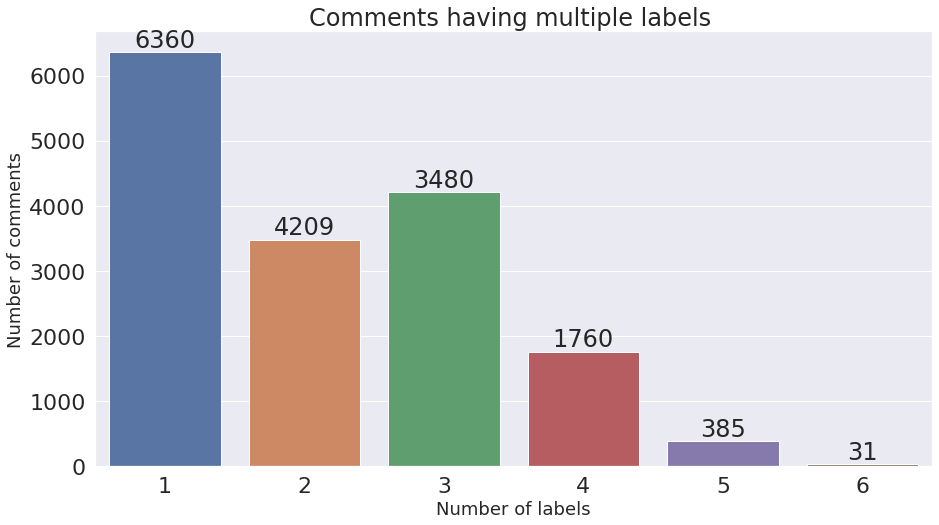

In [ ]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [ ]:
for t in targets:
    print("Label: %s ============================================================" % t)
    b = np.where(df_targets[t]==1)[0]
    selection = np.random.choice(b, 10)
    for s in selection:
        print(train_df.comment_text.loc[s])
        print("++++++++++++")
    print()
    
b = np.where(df_targets.any_label==0)[0]
selection = np.random.choice(b, 10)
print("Clean comments =========================================")
for s in selection:
    print(train_df.comment_text.loc[s])
    print("++++++++++++")

Label: toxic ============================================================
Thanks
Thanks for participating in the conspiracy against me.
++++++++++++
Well i need a way to dance, so suck it
++++++++++++
Message for Angie 

Yo need to get a makeover, u r fuckin ugly bitch.

122.106.27.175
++++++++++++
"

Here you go again. I meant to say TIGHTEN UP not lighten up. As in tighten up and do your job better. Who do you think you are to be constantly correcting me? Now I see why you work for a website because behavior like that will never fly in the real world. You do a shitty job of representing this site. Furthermore, DO NOT try to threaten me by saying I'm going to get blocked because I couldn't give a fuck less. I'm done with this website after what happened yesterday. So ""MS"" fuck you, you little smart ass and fuck wikipedia."
++++++++++++
< Whoever wrote is a cunt
++++++++++++
It is you who are the TROLL FReepsbane. You could not win your arguments by logic so you resorted to framing m

In [ ]:
train_df[train_df.columns[2:]]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
test_labels[test_labels.columns[1:]]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...
153159,-1,-1,-1,-1,-1,-1
153160,-1,-1,-1,-1,-1,-1
153161,-1,-1,-1,-1,-1,-1
153162,-1,-1,-1,-1,-1,-1


In [ ]:
test_labels=test_labels[test_labels.columns[1:]].apply(abs)
y_test=test_labels.values
y_test

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

### Processing


In [ ]:
x_train=train_df["comment_text"]
y_train=train_df[train_df.columns[2:]]   #panda dataframe
y_train=y_train.values      #converting panda dataframe to numpy so that we can pass it through to our DL model
x_test=test_df["comment_text"]

In [ ]:
x_train.head(),y_train

(0    Explanation\nWhy the edits made under my usern...
 1    D'aww! He matches this background colour I'm s...
 2    Hey man, I'm really not trying to edit war. It...
 3    "\nMore\nI can't make any real suggestions on ...
 4    You, sir, are my hero. Any chance you remember...
 Name: comment_text, dtype: object, array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [ ]:
x_test

0         Yo bitch Ja Rule is more succesful then you'll...
1         == From RfC == \n\n The title is fine as it is...
2         " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3         :If you have a look back at the source, the in...
4                 I don't anonymously edit articles at all.
                                ...                        
153159    . \n i totally agree, this stuff is nothing bu...
153160    == Throw from out field to home plate. == \n\n...
153161    " \n\n == Okinotorishima categories == \n\n I ...
153162    " \n\n == ""One of the founding nations of the...
153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 153164, dtype: object

In [ ]:
def replace_abbre(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    # complete -ing
    text = re.sub(r'(\w+in)(\')(\s)', r'\1g\3', text)
    text = text.strip(' ')
    return text


In [ ]:
def replace_url(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [ ]:
def remove_punctuations(words):
    for word in words:
        if word in string.punctuation:
            words = words.replace(word, '')
    return words

In [ ]:
def replace_emoji(data):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  data = emoji_pattern.sub(r'', data)
  return(data)

In [ ]:
# Removing Stop Words
def remove_stopwords(text):
    data = text.copy()      # copy() method is used to avoid overwriting the original data
    stop_words = set(stopwords.words('english'))  # typecasting in set to avoid duplicate values
    
    for word in data:
        if word in stop_words:
            data.remove(word)
            
    return data

In [ ]:
def Remove_stopwords(data):
  stop = stopwords.words('english')
  data = " ".join([word for word in data.split() if word not in (stop)])
  return data

In [ ]:
def remove_extras(data):
  data = re.sub('\s', ' ', data)
  data = re.sub('\n', ' ', data)
  data = re.sub(r"[^a-z.!?\']", " ", data)
  data = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", data)

  return data

In [ ]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
# stemming and lemmatizing
# adapted from the kernal 

def stem_word(text):
    txt = " ".join([stemmer.stem(w) for w in text])
    return text
def lemmatize_word(data):
    return [WordNetLemmatizer().lemmatize(word) for word in data]

In [ ]:
def remove_ip_address(data):
  data = re.sub(r'(([0-9]+\.){2,}[0-9]+)','stmip', data)
  return data

In [ ]:
# Tokenizing the Text
def create_tokens(data):
    return data.lower().split()

In [ ]:
def clean_data(data,lemm):
  #replace abbre
  data=data.apply(replace_abbre)
  #remove stopwords
  data=data.apply(Remove_stopwords)
  #remove punct
  data=remove_punctuations(data)
  #replace emoji
  data = data.apply(replace_emoji)
  #remove extras
  data = data.apply(remove_extras)
  #create token
  data=data.apply(create_tokens)
  # #lemmitization
  data=data.apply(lemm)
  return data


In [ ]:
train_data=clean_data(x_train,lemmatize_word)

In [ ]:
test_data=clean_data(x_test,lemmatize_word)

In [ ]:
train_data

0         [explanation, edits, made, username, hardcore,...
1         [aww, match, background, colour, seemingly, st...
2         [hey, man, really, trying, edit, war, guy, con...
3         [cannot, make, real, suggestion, improvement, ...
4                       [sir, hero, chance, remember, page]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, there, actual, article, prostit...
159569    [look, like, actually, put, speedy, first, ver...
159570    [really, think, understand, came, idea, bad, r...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
test_data

0         [yo, bitch, ja, rule, succesful, ever, whats, ...
1                                   [rfc, title, fine, imo]
2                           [source, zawe, ashton, lapland]
3         [look, back, source, information, updated, cor...
4                              [anonymously, edit, article]
                                ...                        
153159         [totally, agree, stuff, nothing, long, crap]
153160    [throw, field, home, plate, get, faster, throw...
153161    [okinotorishima, category, see, change, agree,...
153162    [one, founding, nation, eu, germany, law, retu...
153163    [stop, already, bullshit, welcome, fool, think...
Name: comment_text, Length: 153164, dtype: object

In [ ]:
def join_words(data):
    data = " ".join([word for word in data])
    return data

In [ ]:
test_data=test_data.apply(join_words)
train_data=train_data.apply(join_words)

In [ ]:
train_data

0         explanation edits made username hardcore metal...
1         aww match background colour seemingly stuck th...
2         hey man really trying edit war guy constantly ...
3         cannot make real suggestion improvement wonder...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm there actual article prostitution ...
159569    look like actually put speedy first version de...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

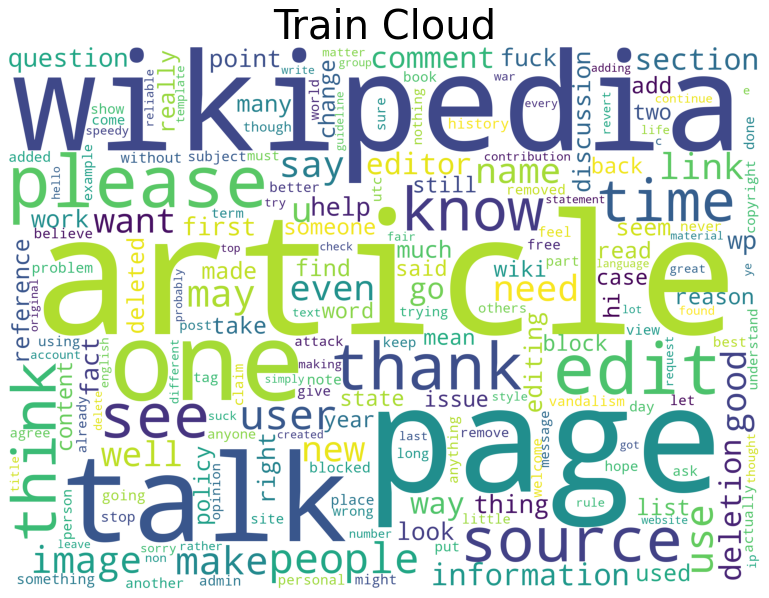

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(15,10))
text = train_data
cloud = WordCloud(   background_color='white',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join((text)))
plt.axis('off')
plt.title("Train Cloud",fontsize=40)
plt.imshow(cloud)

In [ ]:
Max_features = 200000 #maximum words in vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=Max_features,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(x_train.values)

In [ ]:
vectorized_text = vectorizer(x_train.values)

In [ ]:
#for test data
vect_test_data=vectorizer(x_test.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
vect_test_data

<tf.Tensor: shape=(153164, 1800), dtype=int64, numpy=
array([[ 2661,   762, 10794, ...,     0,     0,     0],
       [   31,  1246,     2, ...,     0,     0,     0],
       [  107,     1, 38735, ...,     0,     0,     0],
       ...,
       [    1,  1212,     8, ...,     0,     0,     0],
       [   50,     4,     2, ...,     0,     0,     0],
       [  168,   226,    21, ...,     0,     0,     0]])>

## Fit In ML Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

In [ ]:
test_labels=test_labels[test_labels.columns[1:]].apply(abs)
y_test=test_labels

In [ ]:
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
153159,1,1,1,1,1,1
153160,1,1,1,1,1,1
153161,1,1,1,1,1,1
153162,1,1,1,1,1,1


In [ ]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names,c,fontsize=14):

    df_cm = pd.DataFrame(

        confusion_matrix, index=class_names, columns=class_names,

    )

    heatmap = sns.heatmap(df_cm, annot=True,cmap=c, fmt="d", cbar=False, ax=axes)


    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_ylabel('True label')

    axes.set_xlabel('Predicted label')

    axes.set_title("Confusion Matrix for the class - " + class_label)

In [ ]:
model1 = OneVsRestClassifier(MultinomialNB())
model1.fit(vectorized_text,y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [ ]:
y_pred = model1.predict(vect_test_data)
y_pred

array([[1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1]])

In [ ]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)

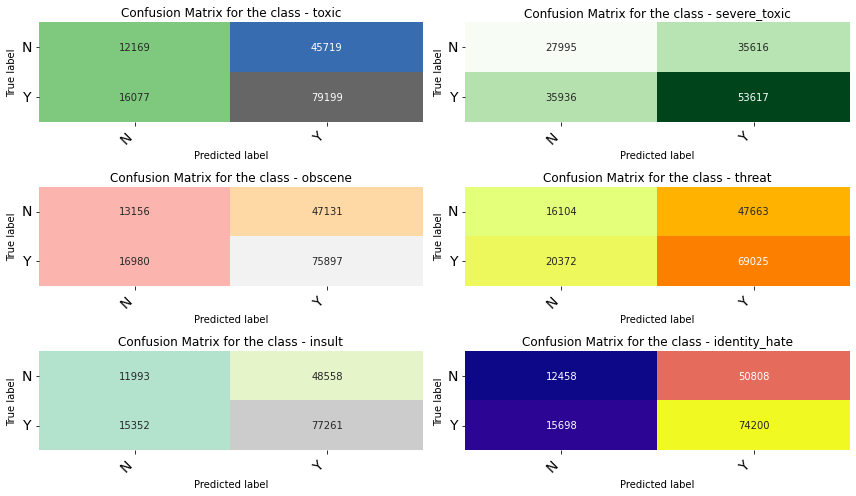

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']    
for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target,range(6)):
    c = cmaps[i]
    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)
fig.tight_layout()
plt.show()

In [ ]:
accuracy_score(y_test,y_pred)

0.37484656969000546

In [ ]:
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=cols_target,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
toxic,0.634008,0.831259,0.719357,95276
severe_toxic,0.600865,0.598718,0.599790,89553
obscene,0.616908,0.817178,0.703059,92877
threat,0.591535,0.772118,0.669869,89397
insult,0.614065,0.834235,0.707415,92613
identity_hate,0.593562,0.825380,0.690534,89898
micro avg,0.609057,0.780910,0.684360,549614
macro avg,0.608490,0.779814,0.681671,549614
weighted avg,0.608834,0.780910,0.682345,549614
samples avg,0.530150,0.490060,0.492580,549614


In [ ]:
model2 = OneVsRestClassifier(LogisticRegression())
model2.fit(vectorized_text,y_train)
y_pred = model2.predict(vect_test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
y_pred

In [ ]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']    
for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target,range(6)):
    c = cmaps[i]
    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)
fig.tight_layout()
plt.show()

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=cols_target,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')

In [ ]:
model3 = OneVsRestClassifier(xgb.XGBClassifier())
model3.fit(vectorized_text,y_train)
y_pred = model3.predict(vect_test_data)
y_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
cfs = []
for i in range(6):
    cf = np.asarray(confusion_matrix(y_test[cols_target[i]], y_pred[:,i]))
    cfs.append(cf)

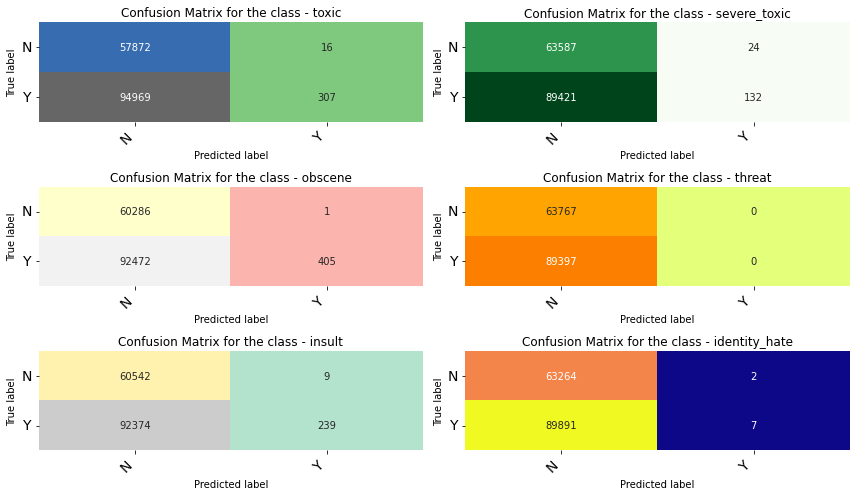

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']    
for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target,range(6)):
    c = cmaps[i]
    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)
fig.tight_layout()
plt.show()

In [ ]:
accuracy_score(y_test,y_pred)

0.3769423624350369

In [ ]:
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=cols_target,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y_train))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(64)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
df_test = tf.data.Dataset.from_tensor_slices((vect_test_data,y_test))
df_test = df_test.cache()
df_test = df_test.shuffle(160000)
df_test = df_test.batch(64)
df_test = df_test.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset
val = df_test.take(int(len(df_test)*.5))
test = dataset.skip(int(len(df_test)*.5)).take(int(len(df_test)*.5))

##2. Create Sequential Model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding,Input

In [ ]:
model3 = Sequential()
# Create the embedding layer 
model.add(Embedding(Max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model3.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=["accuracy"])

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
history3 = model3.fit(train, epochs=20, validation_data=val)

Epoch 1/12
2494/2494 [==============================] - 319s 124ms/step - loss: 0.0643 - accuracy: 0.9811 - val_loss: 3.6058 - val_accuracy: 0.9990
Epoch 2/12
2494/2494 [==============================] - 308s 123ms/step - loss: 0.0437 - accuracy: 0.9887 - val_loss: 4.9241 - val_accuracy: 0.9989
Epoch 3/12
2494/2494 [==============================] - 313s 125ms/step - loss: 0.0370 - accuracy: 0.9767 - val_loss: 5.7260 - val_accuracy: 0.9990
Epoch 4/12
2494/2494 [==============================] - 311s 124ms/step - loss: 0.0320 - accuracy: 0.9929 - val_loss: 5.7751 - val_accuracy: 0.9991
Epoch 5/12
2494/2494 [==============================] - 310s 124ms/step - loss: 0.0280 - accuracy: 0.9759 - val_loss: 7.6383 - val_accuracy: 0.9959
Epoch 6/12
2494/2494 [==============================] - 312s 125ms/step - loss: 0.0244 - accuracy: 0.9681 - val_loss: 9.3206 - val_accuracy: 0.9848
Epoch 7/12
2494/2494 [==============================] - 315s 126ms/step - loss: 0.0215 - accuracy: 0.8982 - val_

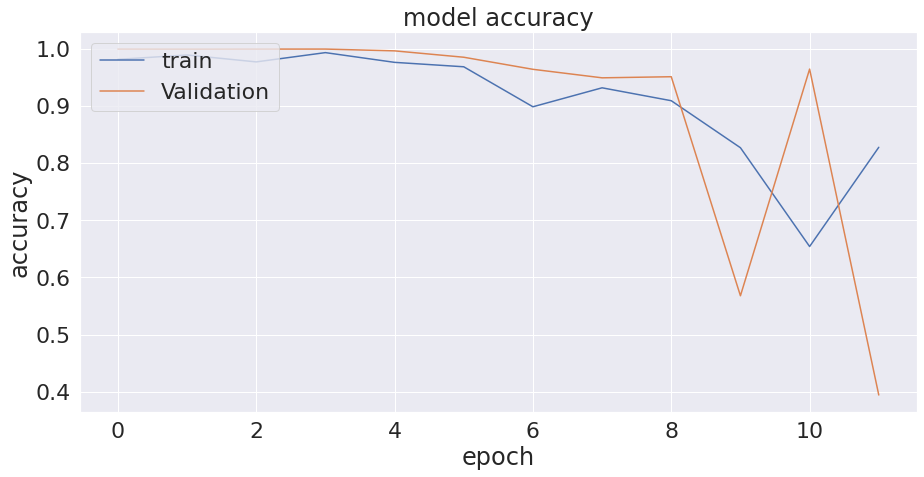

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

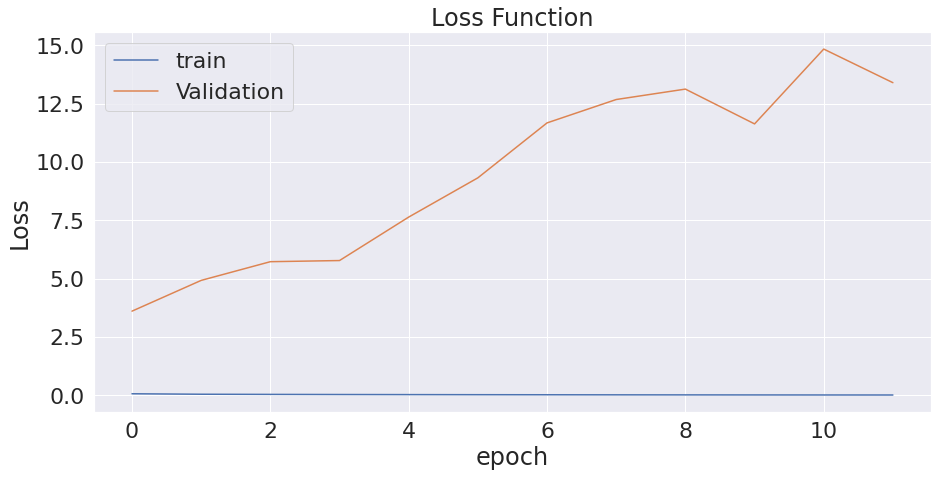

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
results = model3.evaluate(test)

1197/1197 [==============================] - 432s 354ms/step - loss: 0.0124 - accuracy: 0.9891


In [ ]:
# inp=Input(shape=(maxpadlen, ),dtype='int32')
# embedding_layer = Embedding(len(word_index) + 1,
#                            embedding_dim_fasttext,
#                            weights = [embedding_matrix_fasttext],
#                            input_length = maxpadlen,
#                            trainable=False,
#                            name = 'embeddings')
# embedded_sequences = embedding_layer(inp)
# x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
# x = GlobalMaxPool1D()(x)
# x = Dropout(0.2)(x)
# x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
# x = Dropout(0.2)(x)
# preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

# #Compile the Model.
# model4 = Model4(inputs=inp, outputs=preds)
# model4.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# #Fit the Model on Training Data.
# history4=model4.fit(train epochs=2, batch_size=32,  validation_data=val)

##3. Make Predictions


In [ ]:
#prection on test data
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
res=(model3.predict(batch_X) > 0.5).astype(int)
res,res.shape

##4. Evaluate Model


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')

Precision: 0.937217652797699, Recall:0.9753644466400146, Accuracy:0.1938178837299347


##5. Test and Gradio


In [ ]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 4.5 MB/s 
     |████████████████████████████████| 213 kB 50.1 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 2.3 MB 38.7 MB/s 
     |████████████████████████████████| 272 kB 45.6 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 106 kB 69.5 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 80 kB 6.1 MB/s 
     |████████████████████████████████| 68 kB 5.6 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 593 kB 58.1 MB/s 
     |████████████████████████████████| 4.1 MB 41

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity1 (1).h5')

In [ ]:
model1 = tf.keras.models.load_model('toxicity1 (1).h5')

In [ ]:
model2 = tf.keras.models.load_model('Emotion Detection1.h5')

OSError: ignored

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
text=''
res=model1.predict(np.expand_dims(input_str,0))
for idx, col in enumerate(train_df.columns[2:]):
  text += '{}: {}\n'.format(col, res[0][idx]>0.5)
print(text),res

1/1 [==============================] - 0s 122ms/step
toxic: True
severe_toxic: False
obscene: False
threat: False
insult: False
identity_hate: False



(None, array([[0.83739966, 0.00104647, 0.02269941, 0.00153252, 0.26112416,
         0.00191971]], dtype=float32))

In [ ]:
classes=['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
comment='i am very sad today'
vectorized_comment = vectorizer([comment])
vectorized_comment = pad_sequences(vectorized_comment, maxlen=1000, truncating='pre')
# results = classes[np.argmax(model2.predict(vectorized_comment))]
# results

In [ ]:
le = LabelEncoder()
def score_comment(comment):
    # clear_cmt=clean_data(comment)
    vectorized_comment = vectorizer([comment])
    results1 = model1.predict(vectorized_comment)
    text = ''
    for idx, col in enumerate(train_df.columns[2:]):
        text += '{}: {}\n'.format(col, results1[0][idx]>0.5)
    count= 0
    for idx, col in enumerate(train_df.columns[2:]):
      if(results1[0][idx]>0.5):
        count=1
    if(count==0):
      text +="It is a Clean Comment\n"
    else:
      text += "It is a Bad comment\n"
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://a5075cb53ad153a1.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f2afaf09e90>,
 'http://127.0.0.1:7868/',
 'https://a5075cb53ad153a1.gradio.app')